## AutoGluon Exploration and Comparison
### Spotify User Engagement Prediction
#### John Warlick • 1/13/21

In this project, I compare the AutoGluon AutoML library’s performance on an artificially difficult prediction task to related regressors, some of which are constituents of AutoML’s typical data pipeline. 

I discovered that the hype around AutoGluon was not unfounded: it succeeded at prediction greatly compared to other regressors. In doing so, I was able to gather some information on what may have made it succeed so well, which I will be able to apply to future data work. This project serves as a jumping-off point for me to explore the strengths of AutoGluon compared to typical/standalone regressors, compare said regressors, and to develop my own knowledge about the benefits of advanced ensemble constructions.

### Background

AutoGluon is an AutoML library that aggregates several types of regressors to make predictions. Like similar AutoML libraries, you could call it a self-customizing data pipeline, in that it selects the regressors that perform best for a task and then weighs them according to its own internal logic to provide a single prediction. In short, it is a massively simplified means for testing and using many different regressors to solve one problem. When I first learned about it and found it was available open-source, I knew I had to test it out, and I finally had a chance to do so over the holidays between quarters of my graduate program at UCLA. 

There are many examples posted online of AutoGluon succeeding quickly and wildly for tasks simpler regressors might take slightly longer to give slightly worse predictions for. So, my aim with this first AutoGluon project I’ve done was to do something a little different. I wanted to give AutoGluon a prediction task that was extremely difficult (if not impossible), and see what it might do. In examining its attempts to resist failure, I learned a little bit about how AutoGluon faces its problems.

I call the prediction task at hand extremely difficult because I have intentionally removed features of the dataset that might make it slightly less so. Spotify’s Sequential Skip Prediction Challenge (SSSPC) was a crowdAI data challenge in which participants were given many millions of music streaming platform Spotify users’ time-series consumption data for a single session on the platform, along with another data set containing each individual song’s “audio features” (many of which are intentionally-opaque measures calculated by Spotify’s proprietary algorithms). Participants were asked to predict whether users skipped the songs they encountered for the latter half of their session, given only the data on what songs they listened to and whether they skipped them in the first half of their session. This kind of prediction task is the bread and butter for Spotify, whose famed recommendation algorithm is adept at doing exactly this, knowing what people want to listen to before they even do. Many entrants of this competition have released papers detailing the data pipelines they discovered were most effective for this task, most involving a melding of recurrent neural networks and random forests. The best solutions to this challenge that I have encountered involved carefully designed encoder-decoder architectures of recurrent neural networks with bi-directional long short-term memory layers (see: Sain Athadapa’s elegant submission).

For this current project, which is much more exploratory than the challenge itself, I have examined how AutoGluon fares in predicting the ratio of user skips to full plays for every song in the SSSPC data set using _only_ the audio features provided by Spotify. In the absence of the time-series user data contextualizing when they encountered each song in their listening session, as well as other user-centric contextual data, I would deem this prediction task to be extremely difficult. After all, each and every person has a unique taste in music, and if computers could predict how often people would choose to listen to a song by its audio qualities alone, record label A&R men would be out of a job. That doesn’t mean no one’s trying to do exactly that, but it shouldn’t be simple for even the best AutoML pipeline to accomplish, and for that reason I thought it would provide interesting performance comparisons between regressors.

### Approach / Data Cleaning

Since AutoGluon is only supported by up to version 3.7 of Python and is most stable in Linux, I made an analogous virtual environment in an Amazon Web Services EC2 instance, sorted out some dependencies, and was off to work. 

I will try this prediction task first with a simple Linear Regression model, then with a RandomForest, an ExtraTrees forest, a basic Keras Convolutional Neural Network, and finally with AutoGluon.

In [4]:
import pandas as pd
import numpy as np
import glob

# Join all training set files together, and join all test set files together
li = []
trainsetfiles = glob.glob("training_set/*.csv") 
testsetfiles = glob.glob("test_set/log_prehistory*.csv") 

# Combine relevant features for play ratio prediction from both training and test files in one dataframe
for filename in trainsetfiles + testsetfiles:
    df = pd.read_csv(filename)[['track_id_clean', 'not_skipped']]
    li.append(df)

train = pd.concat(li, axis=0)

First, I engineered the dataset to fit my needs by selecting the operative columns for the task at hand and deleting duplicate rows. I then manually engineered the “play ratio” of each song appearing in the dataset, defined as the ratio of full plays over all times the song was encountered, summed across all users.

In [5]:
# Feature engineering: make 'plays' feature from sum of plays on each unique track_id,
# and 'counts' to indicate how many times each unique track was not skipped
counts = train.groupby(['track_id_clean', 'not_skipped']).size().to_frame('counts').reset_index()
train['plays'] = train.groupby('track_id_clean')['track_id_clean'].transform('count')
train = train.sort_values(['track_id_clean', 'not_skipped'], ascending=[True, True]).reset_index(drop=True)
train = train.drop_duplicates(subset='track_id_clean', keep='first', inplace=False).reset_index(drop=True)
counts = counts.sort_values(['track_id_clean', 'not_skipped'], ascending=[True, False])
counts = counts.drop_duplicates(subset='track_id_clean', keep='first', inplace=False).reset_index(drop=True)
train = train.drop(['not_skipped'], axis=1).join(counts.set_index('track_id_clean'), on='track_id_clean')

# Make 'play_ratio' feature from ratio of not-skipped songs to total appearances
train['play_ratio'] = 0.0
for i, row in train.iterrows():
    playratio = row['counts'] / float(row['plays'])
    if row['not_skipped'] == True:
        train.at[i, 'play_ratio'] = playratio

Next, I normalized the track features that weren’t already in veritably standardized form. I also chose to drop certain variables, which others may have chosen to one-hot encode as categorical variables: in my prior experience as a music producer and recording engineer, I have developed a well-educated hunch that a song's key and mode (that is, major versus minor) have no bearing on its success whatsoever. I can generally say the same about a song's time signature; the most common time signatures are common because people like them, and the uncommon ones (e.g. 5/4, 7/4, 13/8) don't have as much bearing on a song's success as the other decisions made in the song (see: the wide gulf in streams between Taylor Swift's "tolerate it" and "closure", two songs in 5/4 on the same album with very different aesthetic features).

In [6]:
# Load and combine data sets containing audio features from each track
track1 = pd.read_csv('track_features/tf_000000000000.csv')
track2 = pd.read_csv('track_features/tf_000000000001.csv')
tracks = pd.concat([track1, track2])

# Normalize widely-ranged continuous variables 
tracks['release_year'] = (tracks['release_year'] - min(tracks['release_year'])) / (max(tracks['release_year']) - min(tracks['release_year']))
tracks['us_popularity_estimate'] = (tracks['us_popularity_estimate'] - min(tracks['us_popularity_estimate'])) / (max(tracks['us_popularity_estimate']) - min(tracks['us_popularity_estimate']))
tracks['dyn_range_mean'] = (tracks['dyn_range_mean'] - min(tracks['dyn_range_mean'])) / (max(tracks['dyn_range_mean']) - min(tracks['dyn_range_mean']))
tracks['duration'] = (tracks['duration'] - min(tracks['duration'])) / (max(tracks['duration']) - min(tracks['duration']))
tracks['tempo'] = (tracks['tempo'] - min(tracks['tempo'])) / (max(tracks['tempo']) - min(tracks['tempo']))
tracks['loudness'] = (tracks['tempo'] - min(tracks['tempo'])) / (max(tracks['tempo']) - min(tracks['tempo']))

# Drop unneeded variables
tracks = tracks.drop(['key', 'mode', 'time_signature'], axis=1)

Afterwards, I checked the distributions of each continuous variable. They all fall in the same relative location of value ranges, and have similar absolute ranges. While most features have something approximating a normal distribution, features like 'instrumentalness' and 'acousticness' have odd, distinctively bipolar distributions, and many other features have clear left or right skew. Because I'm looking forward to seeing how AutoGluon handles these distributions, I have not transformed any of these variables, but will be keeping an eye on how their distributions may affect their selection as features.

In [23]:
tracks.head()

,track_id,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,...,tempo,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
0,t_2e8f4b71-8a0b-4b9c-b7d8-fb5208e87f9f,0.167239,0.304348,0.958289,0.716209,0.366495,0.332605,0.439835,0.110348,0.238847,...,0.401501,0.223395,0.146012,-0.706908,0.259496,0.481157,0.238427,-0.098389,-0.254960,-0.227383
1,t_dae2ec0e-ec7b-4b3e-b60c-4a884d0eccb0,0.066561,0.188406,0.727204,0.839460,0.362212,0.389829,0.507580,0.130109,0.420476,...,0.565365,0.484702,0.039554,-0.539554,0.105141,0.692589,0.226047,-0.468162,0.164389,-0.769024
2,t_cf0164dd-1531-4399-bfa6-dec19cd1fedc,0.045423,0.347826,0.962039,0.054673,0.495002,0.589378,0.552311,0.177940,0.842938,...,0.555589,0.818441,0.083863,-0.242108,-0.014258,0.096396,0.417641,-0.050576,-0.204757,-0.172563
3,t_0f90acc7-d5c5-4e53-901d-55610fbd090c,0.117318,0.550725,0.679683,0.042606,0.389634,0.359044,0.585673,0.115343,0.665398,...,0.532584,0.594829,0.192498,0.340039,0.034846,-0.389794,0.518381,0.185008,-0.079907,-0.016978
4,t_36b9ad02-095a-443d-a697-6c7285d9410a,0.081694,0.536232,0.790589,0.249982,0.513640,0.485435,0.635095,0.136824,0.408715,...,0.608880,0.591289,0.270586,-0.411061,0.165898,0.225652,0.335518,-0.036643,-0.016300,-0.446870


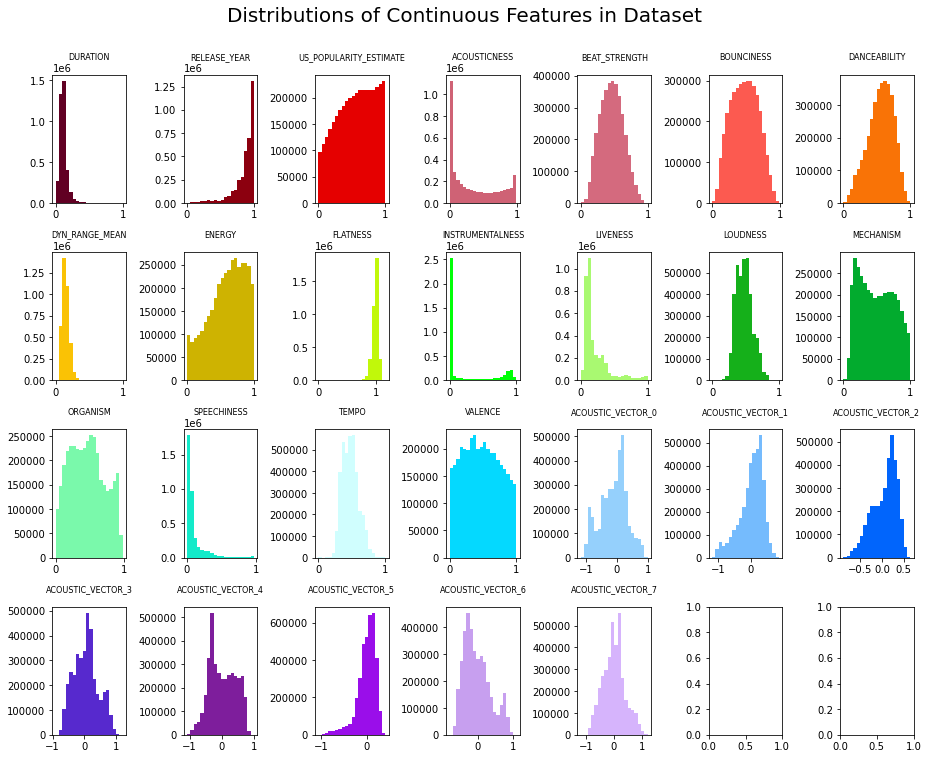

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 7, figsize=(13, 10))

colors = ['xkcd:burgundy', 'xkcd:crimson', 'xkcd:red', 'xkcd:rose', 'xkcd:pinkish', 'xkcd:coral','xkcd:orange','xkcd:goldenrod', 'xkcd:mustard', 'xkcd:chartreuse', \
          'xkcd:bright green','xkcd:spring green','xkcd:green', 'xkcd:kelly green',  'xkcd:seafoam green', 'xkcd:aqua', \
          'xkcd:pale blue', 'xkcd:neon blue','xkcd:light blue','xkcd:sky blue', 'xkcd:bright blue', 'xkcd:blue purple','xkcd:purple','xkcd:violet','xkcd:lavender',\
          'xkcd:light violet']

# Graph continuous features to observe distributions
cont_feats = tracks.drop(['track_id'], axis=1)

for ax, feat, col in zip(axes.flatten(), cont_feats.columns, colors):
    x = cont_feats[feat]
    ax.hist(x, bins=20, label=str(feat), color=col)
    ax.set_title(feat.upper(), fontsize = 8, y = 1.07)
            
plt.suptitle('Distributions of Continuous Features in Dataset', fontsize = 20, y = 1.05)
plt.tight_layout()
plt.show()

In [42]:
# Merge user behavior data with track audio feature data
tracks2 = tracks
tracks2 = tracks2.merge(train, how='right', left_on='track_id', right_on='track_id_clean')

# Remove all tracks not appearing at least 20 times throughout data
tracks2 = tracks2[tracks2['plays'] >= 20]

# Remove all unnecessary features for task at hand
tracks2 = tracks2.drop(['plays', 'counts', 'track_id', 'track_id_clean', 'not_skipped'], axis=1)

Because there are so many songs on Spotify, many songs in the dataset were only encountered once, so I filtered the songs down to only songs appearing at least 20 times, resulting in an N of around 145,000. 

After randomly splitting the data, we can start comparing regressors in their performance in predicting these tracks' skip/play ratios.

In [43]:
from sklearn.model_selection import train_test_split

# Split data into training and test samples
train, test = train_test_split(tracks2, random_state = 20, test_size=0.2)
train.to_csv(r'Skip_training.csv', index=False)
test.to_csv(r'Skip_test.csv', index=False)
y_tr = train[['play_ratio']].reset_index(drop=True)
X_tr = train.drop(['play_ratio'], axis=1).reset_index(drop=True)
y_test = test[['play_ratio']].reset_index(drop=True)
X_test = test.drop(['play_ratio'], axis=1).reset_index(drop=True)

### Linear Regression

Before getting into prediction with Forests and Neural Networks, setting a base comparison with an ordinary linear regression model will be useful.

In [44]:
from sklearn.linear_model import LinearRegression

# Instantiate and fit Linear Regression model
lm = LinearRegression()
_ = lm.fit(X_tr, y_tr)

#### Results

In [45]:
from sklearn.metrics import mean_squared_error

# Predict on Linear Regression model
y_pred = lm.predict(X_test)
print(f"The linear regression model's RMSE on the test data is {mean_squared_error(y_test, y_pred, squared=False)}.")

The linear regression model's RMSE on the test data is 0.10972723365784956.


The linear regression model, on average, showed a 10.97% error for predicting skip rates for Spotify songs given their audio features. This is a good baseline for evaluating whether the regressors to come are adding any value to this prediction problem. Linear regression here provided extremely quick predictions (within seconds) compared to the normal prediction times for the regressors to come, so if other regressors can't beat this error by much, it shows their worth for this kind of problem.

In [46]:
# Calculate Linear Regression feature importances
importances = lm.coef_
imp_dict = {X_test.columns[i]: importances[0][i] for i in range(len(importances[0]))}
sorted_tups = sorted(imp_dict.items(), key=lambda item:item[1])
sorted_imps = {i:j for i, j in sorted_tups}

print('Linear Regression Feature Importances:\n')
for feat, imp in sorted_imps.items():
    print(f'{feat:<25} {imp:>30.5f}')

Linear Regression Feature Importances:

duration                                        -0.71253
dyn_range_mean                                  -0.43762
acoustic_vector_3                               -0.09898
acoustic_vector_1                               -0.09207
flatness                                        -0.08003
acoustic_vector_5                               -0.07000
danceability                                    -0.01932
energy                                          -0.01901
beat_strength                                   -0.00842
loudness                                        -0.00437
tempo                                           -0.00437
liveness                                         0.00105
valence                                          0.01338
acousticness                                     0.01361
acoustic_vector_0                                0.01531
mechanism                                        0.01818
acoustic_vector_2                               

On an intuitive level, it makes a lot of sense what a simple linear regression would pick for predicting skips on a Spotify song. 'duration' has the lowest and greatest-magnitude coefficient out of all features in the regression, owing to the fact that the longer a given song is, the more time a user has to skip it. More popular songs also tend to be shorter, because they are more 'digestible', demanding less resources to consume. The next largest coefficient, 'dyn_range_mean', is also sensibly negative, as songs with less dynamic range tend to be songs that are loud throughout their entire runtime, which are naturally interpreted as more exciting and easier for the listener to keep engaged with than songs with lulls in their dynamic. The third-highest-magnitude coefficient is also the highest positive coefficient, and is for the feautre 'us_popularity_estimate', which is actually not an audio feature per sé, but more of a measure of how many listens a song has. Of course, more popular songs tend to be listened to more, so it's obvious why this would be an important coefficent for a simple linear predictor. It will be noteworthy to see how these features change in importance in the regressors to come.

### Random Forest

I outfitted a RandomForest regressor for the prediction task and tuned its hyperparameters with GridSearch using options I thought were appropriate. The GridSearch below is actually the second one I completed; in response to the first's results, I explored a different set of hyperparameter values. Although I would have liked to do yet another run, and would have preferred to cross-validate a little more on the GridSearch, as you can see from the elapsed time, doing so would have been prohibitively time-expensive. (This elapsed timing comes from my laptop; AWS processing with the inexpensive instance I'm working with was slower.)

In [48]:
from sklearn.ensemble import RandomForestRegressor

# Instantiate Random Forest regressor
rf = RandomForestRegressor(random_state=20)

# Define hyperparameter grid for GridSearch
param_grid = {
    'max_depth': [2,4,6,8],
    'max_features': [3,5,10,25],
    'min_samples_leaf': [.01,.05,.1,.2],
    'min_samples_split': [.01,.05,.1,.2],
    'n_estimators': [2, 8, 25, 100, 200] 
}

In [78]:
from sklearn.model_selection import GridSearchCV

# Instantiate GridSearchCV and perform grid search
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 2, scoring='neg_root_mean_squared_error', n_jobs = -1, verbose = 2) 
grid_search.fit(X_tr, y_tr)

Fitting 2 folds for each of 1280 candidates, totalling 2560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed: 19.4min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed: 37.2min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed: 61.1min
[Parallel(n_jobs=-1)]: Done 2560 out of 2560 | elapsed: 87.3min finished
/Users/johnwarlick/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=2, estimator=RandomForestRegressor(random_state=20), n_jobs=-1,
             param_grid={'max_depth': [2, 4, 6, 8],
                         'max_features': [3, 5, 10, 25],
                         'min_samples_leaf': [0.01, 0.05, 0.1, 0.2],
                         'min_samples_split': [0.01, 0.05, 0.1, 0.2],
                         'n_estimators': [2, 8, 25, 100, 200]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [79]:
# Print the best hyperparameters
best_hyperparams = grid_search.best_params_
print('Best hyperparameters:\n', best_hyperparams)

# Print the best score
best_score = grid_search.best_score_
print('Best score:', best_score)

Best hyperparameters:
 {'max_depth': 8, 'max_features': 10, 'min_samples_leaf': 0.01, 'min_samples_split': 0.01, 'n_estimators': 100}
Best score: -0.10834693136389512


In [49]:
# Using the best hyperparameters, re-instantiate the Random Forest and fit to training data
best_forest = RandomForestRegressor(random_state=20, max_depth=8, max_features=10,\
                                    min_samples_leaf=0.01, min_samples_split=0.01, n_estimators=100)

best_forest.fit(X_tr, np.ravel(y_tr))

RandomForestRegressor(max_depth=8, max_features=10, min_samples_leaf=0.01,
                      min_samples_split=0.01, random_state=20)

In [50]:
from sklearn.metrics import mean_squared_error

# Make predictions on test set with Random Forest and calculate RMSE
y_pred = best_forest.predict(X_test)
print(f"The random forest's RMSE on the test data is {mean_squared_error(y_test, y_pred, squared=False)}.")

The random forest's RMSE on the test data is 0.10845876484715616.


#### Results
In the end, the best random forest specified from GridSearch has a root mean squared error of .109, which would correspond to an average of 10.9% error in predicting every track in the testing data's true play/skip ratio. To me, this isn't terrible, but I think we can do better.

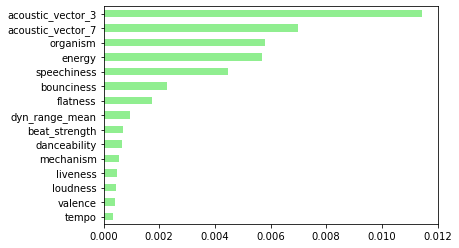

In [51]:
# Feature importances in best Random Forest model
importances = pd.Series(best_forest.feature_importances_, index = X_test.columns)
sorted_importances = importances.sort_values()
sorted_importances[0:15].plot(kind='barh', color='lightgreen')
plt.show()

The features selected here are interesting. The acoustic vectors that Spotify provides as track features are inherently unexplainable (they are calculated by proprietary algorithms by "Music DNA Company" The Echo Nest, which Spotify acquired in 2014), but 'energy' and 'organism' (a quantization of 'organic' music qualities) are surely sensible factors to be driving user engagement with particular songs. Many listeners listen to music in an effort to catch the 'energy' (e.g. gym-goers trying to find music for exercise), and Spotify defines the audio feature on its website as being analogous to "intensity" and "activity", or songs that feel loud and noisy. Louder content has been proven time and time again to be more engaging and exciting than quieter content, and it makes sense why listeners would be drawn to tracks that have it in spades. That being said, it's important to note 'energy' doesn't capture exactly the same thing as the audio feature 'loudness' itself (which is a measure of average loudness). 'Organism', on the other hand, may be a result of current trends in music. Particularly in instrumental music, softer, more 'natural' sounds have become popular in the last few years, coinciding with the rising appeal of 'ASMR' audio in short-form video content. In other words, recent trends see listeners gravitating towards calmer, more natural and human-recalling sounds, so it's unsurprising that 'organism' is a helpful determinant of whether users will like a given track on Spotify. Examining the features in comparison to their distributions, it doesn't appear that normality or lack thereof drove these selections, but the oddly bipolar features appear absent, so it will be intriguing to see if AutoGluon selects those differently.

### ExtraTreesRegressor

Now that we've seen this prediction task's performance with a RandomForest, I thought it might be illuminative to have an ExtraTrees regressor comparison. The two regressors may be similar, but there are a few properties of the data set that I thought made it worth looking into. For one, the sheer variation between each row in this dataset -- that is, the uniqueness of each song -- makes the bootstrapping involved in Random Forests a more intuitive processing decision than it would be with other datasets, but may also randomly exaggerate the importance of outlier feature values from particular observations. Thus, the fact that all trees in ExtraTrees forests are trained with the complete data set may provide telling performance differences. Also, this data set has features with many different distributions, and it may be interesting to note how an ExtraTreesRegressor's random splitting at each node affects performance and feature selection compared to RandomForests' more "optimal" splitting.

In [52]:
from sklearn.ensemble import ExtraTreesRegressor

# Instantiate ExtraTrees regressor
etf = ExtraTreesRegressor(random_state=20)

# Define hyperparameter grid for GridSearch
param_grid = {
    'max_depth': [2,8,16,25,50],
    'max_features': [3,5,10,25],
    'min_samples_leaf': [.01,.05,.1,.2],
    'min_samples_split': [.01,.05,.1,.2],
    'n_estimators': [2, 8, 25, 100, 200] 
}

In [66]:
from sklearn.model_selection import GridSearchCV

# Instantiate GridSearchCV and perform grid search
grid_search = GridSearchCV(estimator = etf, param_grid = param_grid, cv = 2, scoring='neg_root_mean_squared_error', n_jobs = -1, verbose = 2) 
grid_search.fit(X_tr, np.ravel(y_tr))

Fitting 2 folds for each of 1600 candidates, totalling 3200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   54.1s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed: 18.1min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed: 25.5min
[Parallel(n_jobs=-1)]: Done 3200 out of 3200 | elapsed: 33.8min finished


GridSearchCV(cv=2, estimator=ExtraTreesRegressor(random_state=20), n_jobs=-1,
             param_grid={'max_depth': [2, 8, 16, 25, 50],
                         'max_features': [3, 5, 10, 25],
                         'min_samples_leaf': [0.01, 0.05, 0.1, 0.2],
                         'min_samples_split': [0.01, 0.05, 0.1, 0.2],
                         'n_estimators': [2, 8, 25, 100, 200]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [67]:
best_hyperparams = grid_search.best_params_
print('Best hyperparameters:\n', best_hyperparams)

# Print the best score
best_score = grid_search.best_score_
print('Best score:', best_score)

Best hyperparameters:
 {'max_depth': 16, 'max_features': 25, 'min_samples_leaf': 0.01, 'min_samples_split': 0.01, 'n_estimators': 100}
Best score: -0.10945875396030427


In [53]:
# Using the best hyperparameters, re-instantiate the ExtraTrees regressor and fit to training data
best_extra_forest = ExtraTreesRegressor(random_state=20, max_depth=16, max_features=25,\
                                    min_samples_leaf=0.01, min_samples_split=0.01, n_estimators=100)

best_extra_forest.fit(X_tr, np.ravel(y_tr))

ExtraTreesRegressor(max_depth=16, max_features=25, min_samples_leaf=0.01,
                    min_samples_split=0.01, random_state=20)

In [54]:
from sklearn.metrics import mean_squared_error

# Make predictions on test set with ExtraTrees regressor and calculate RMSE
y_pred = best_extra_forest.predict(X_test)
print(f"The Extra Trees Forest's RMSE on the test data is {mean_squared_error(y_test, y_pred, squared=False)}.")

The Extra Trees Forest's RMSE on the test data is 0.10974964170245556.


#### Results
In the end, the best random forest specified from GridSearch has a root mean squared error of .1098, which would correspond to an average of 10.98% error in predicting every track in the testing data's true play/skip ratio. This performance is worse than the RandomForest, and is actually marginakky worse than our baseline linear regression model! In hindsight, it may not have been worth the time spent tuning its hyperparameters.

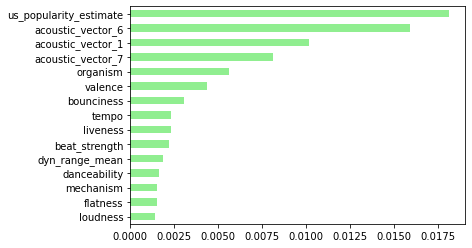

In [55]:
# Feature importances in best ExtraTrees model
import matplotlib.pyplot as plt
importances = pd.Series(best_extra_forest.feature_importances_, index = X_test.columns)
sorted_importances = importances.sort_values()
sorted_importances[0:15].plot(kind='barh', color='lightgreen')
plt.show()

Although it would be easy to ignore the feature importance of this ExtraTreesRegressor because of its inferior performance, it's fascinating to note how differently it assigned feature importances compared to the RandomForest we studied. The two Forests only share 'organism' and 'acoustic_vector_7' in their top 3 features. Interestingly, the most important features in the ExtraTreesForest seem to be more important on average than those in the RandomForest's listing; in particular, the top 4 features here had importance magnitudes greater than 0.0075 compared to only the very top feature in the RandomForest, and the top 2 features in this forest were deemed more predictive than top feature of the RandomForest. 'us_popularity_estimate', the most predictive feature here, is nowhere to be found in the top features of the RandomForest, which seems strange, because popularity is inarguably an intuitive predictor of whether a song will be listened to by a random user. Of course, it's also one of the few 'audio features' of this dataset that is not an audio feature at all; it's a proxy of overall engagement across all users. Because one can't separate features from their omitted variables in Forests the same way that one can with linear regression models, one could argue that 'us_popularity_estimate' could stand in here for correlated audio features that determine popularity. However, as we'll see later, it's not apparent there are many directly correlated acoustic features with popularity.

One can speculate whether the lack of bootstrapping or the presence of random splits led to the very clear difference in feature importance here compared to RandomForests, and I would personally guess it has to do with bootstrapping. Although bootstrapping in RandomForests is said to reduce overfitting, the effect of having repeat rows with near-extreme feature values can be said in itself to randomize the extent that particular observations lead the model to 'overfit', potentially exaggerating the usefulness of particular features for predicting skips on a particular song, and leading them to be considered more predictive than they may have been otherwise. This may seem counterintuitive for extending prediction to other songs, but over a large pool of songs, those individual-song feature exaggerations may better capture how specific features predict skips than the forest would without bootstrapping. In any case, it may look odd that this ExtraTreesRegressor performed worse overall than the RandomForestRegressor even though it had greater-magnitude feature importances, but with such an 'impossible' task as predicting skips based on audio features alone, I think it makes some sense. Perhaps spreading feature importance across more audio features is a surer approach for this prediction task than relying more on a few specific features.

### Convolutional Neural Network

Neural nets are not typically used for regression problems because they’re not typically _needed_ for such tasks. Deep learning is particularly helpful for tasks with multidimensional outputs like image recognition and audio processing, and many effective techniques for simple tabular prediction predate neural networks, so many data scientists call them ‘overkill’ for predicting continuous values. However, because AutoGluon’s unique neural network is one of the best-performing components of the prediction pipeline that does well with tasks like the one we're experimenting with, so a more typical neural net’s performance is a handy comparison.
 
Here, I've constructed a somewhat conventional convolutional neural network, with a small modification in the output layer. Normally, one would want to outfit a CNN for regression with a linear activation function for its output layer, because the final prediction should be an unbounded continuous variable. However, in this problem a sigmoid activation works as well, because our final prediction is bounded between 0 and 1. In fact, with every configuration of layers and units I tested (not explored here for space considerations), a sigmoid activation function for the output layer performed better than a linear activation function.

In [56]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Bidirectional, Dense, Flatten
from keras.layers import Dense, Flatten

# Define Convolutional Neural Network architecture
def build_cnn_model():
    model = Sequential()
    model.add(Dense(units = X_tr.shape[1] * 2, kernel_initializer='normal', input_dim = X_tr.shape[1], activation='relu'))
    model.add(Dense(units = X_tr.shape[1] * 4, kernel_initializer='normal', activation='relu'))
    model.add(Dense(units = X_tr.shape[1] * 4, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    ######################
    model.compile(optimizer='adam',loss='MeanSquaredError',metrics=['RootMeanSquaredError'])

    return model

# Instantiate CNN
model = build_cnn_model()

In [57]:
# Fit CNN
model.fit(X_tr, y_tr, epochs=20, validation_split = 0.25)

Epoch 1/20
4180/4180 [==============================] - 3s 738us/step - loss: 0.0120 - root_mean_squared_error: 0.1098 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1063
Epoch 2/20
4180/4180 [==============================] - 3s 831us/step - loss: 0.0114 - root_mean_squared_error: 0.1066 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1069
Epoch 3/20
4180/4180 [==============================] - 4s 1ms/step - loss: 0.0113 - root_mean_squared_error: 0.1061 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1053
Epoch 4/20
4180/4180 [==============================] - 3s 805us/step - loss: 0.0112 - root_mean_squared_error: 0.1057 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1069
Epoch 5/20
4180/4180 [==============================] - 3s 829us/step - loss: 0.0111 - root_mean_squared_error: 0.1054 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1054
Epoch 6/20
4180/4180 [==============================] - 4s 855us/step - loss: 0.0110 - root_mean_squared_error: 0.1051 - v

In [58]:
from sklearn.metrics import mean_squared_error

# Predict on CNN and calculate RMSE
y_pred = model.predict(X_test) 
rms = mean_squared_error(y_pred, y_test, squared=False)
print(f"The neural net's RMSE on the test data is {rms}.")

The neural net's RMSE on the test data is 0.10430304816099194.


#### Results:
In the end, the convolutional neural network had a mean error of 10.4% on the testing data, about .4% lower than the best RandomForest we utilized. This is a curious result, because as previously mentioned, Neural Networks are not thought to be as useful for regression problems like these ones, especially compared to forest-type regressors. Perhaps the unique complexities involved in this data set and the 'impossible' nature of the problem change our assumptions about what a neural network is supposed to do worse in this scenario; there is no neat formula for success in a problem that aims to predict human preferences. To put it in a somewhat non-scientific way, maybe it's fitting that a neural network doesn't do too bad of a job predicting a human brain's decisionmaking.

### AutoGluon

In [2]:
from autogluon import TabularPrediction as task

# Load training and test data for AutoGluon
train_data = task.Dataset(file_path='Data/Skip_training.csv')
test_data = task.Dataset(file_path='Data/Skip_test.csv')

# Fit AutoGluon to training data
predictor_playratio = task.fit(train_data=train_data, output_directory="Data/autogluon-predictratio", label='play_ratio')

/home/ubuntu/anaconda3/envs/AG_env/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Loaded data from: Data/Skip_training.csv | Columns = 27 / 27 | Rows = 178342 -> 178342
Loaded data from: Data/Skip_test.csv | Columns = 27 / 27 | Rows = 44586 -> 44586
Beginning AutoGluon training ...
AutoGluon will save models to Data/autogluon-predictratio/
AutoGluon Version:  0.0.15
Train Data Rows:    178342
Train Data Columns: 26
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (1.0, 0.0, 0.33699, 0.11983)
	If 'regression' is not the correct problem_type, please 

In [3]:
# Check predictive performance (RMSE) of AutoGluon on test data
performance = predictor_playratio.evaluate(test_data)

/home/ubuntu/anaconda3/envs/AG_env/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Predictive performance on given dataset: root_mean_squared_error = 0.10096534238678567


#### Results:
The root mean squared error for AutoGluon on the prediction task was around 10.1%, a whole .3% better than the neural network we used.

In [4]:
# Calculate AutoGluon importance scores
importance_scores = predictor_playratio.feature_importance(test_data)

/home/ubuntu/anaconda3/envs/AG_env/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Computing raw permutation importance for 26 features on weighted_ensemble_k0_l1 ...
	223.59s	= Expected runtime
	198.59s	= Actual runtime


In [5]:
print(importance_scores)

duration                  0.008465
us_popularity_estimate    0.004614
release_year              0.004188
acoustic_vector_0         0.004098
acoustic_vector_2         0.002579
acoustic_vector_4         0.002421
acoustic_vector_5         0.001728
acoustic_vector_7         0.001663
instrumentalness          0.001507
acoustic_vector_6         0.001483
acoustic_vector_3         0.001353
speechiness               0.001226
energy                    0.001035
acoustic_vector_1         0.001002
acousticness              0.000968
organism                  0.000891
beat_strength             0.000590
dyn_range_mean            0.000578
mechanism                 0.000471
loudness                  0.000333
flatness                  0.000209
tempo                     0.000178
danceability              0.000176
bounciness                0.000121
liveness                  0.000088
valence                   0.000057
dtype: float64


/home/ubuntu/anaconda3/envs/AG_env/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


It's very interesting how much AutoGluon's feature importances vary from the forests trained earlier. While the RandomForest and ExtraTreesRegressor weighed 'organism' as one of the most important features for prediction, AutoGluon ranked it in the bottom half of the dataset's features, instead focusing on song duration ('duration'), its popularity ('us_popularity_estimate'), and its release year ('release_year'). These choices are more in line with our simplest model, the linear regression. Few people would argue that these latter features are all extremely important determinants of people listening to a complete song: that it's not too long, it's a song that other people listen to, and that it's new or topical. It's interesting, though, that 'release_year' showed up so high here and not in any of our other regressors' feature importances. As one can see in the heat map below, it doesn't seem to highly correlate with any other feature, so why was it overlooked in other regressors? I don't have a great answer for this just yet. Another curious detail to note is that AutoGluon doesn't prize 'dyn_range_mean' as highly as the other regressors we studied. However, as we'll also see below, there are high correlations of that feature with other features that are listed higher in importance here, so this is not wholly surprising. Rather, it may hint that AutoGluon's ensembling does a good job in prediction because it does a good job in rejecting high-magnitude, coarsely-predicting features in favor of collinear/constituent features that more finely predict skips.

Looking at the features selected, and examining their distributions, there is again no connection between normality of distribution and feature selection - the top-selected features all have distinct distributions. Also, one of the bipolar-distributed features we noted earlier in this project, 'instrumentalness', is near the top of the list, which implies that AutoGluon truly does undergo a distribution-indifferent feature selection process.

Now that we've reviewed regressor performance and feature selection, we might get more insight from making sure none of our features are essentially representing the same thing. Let's make a correlation matrix to check for multicollinearity.

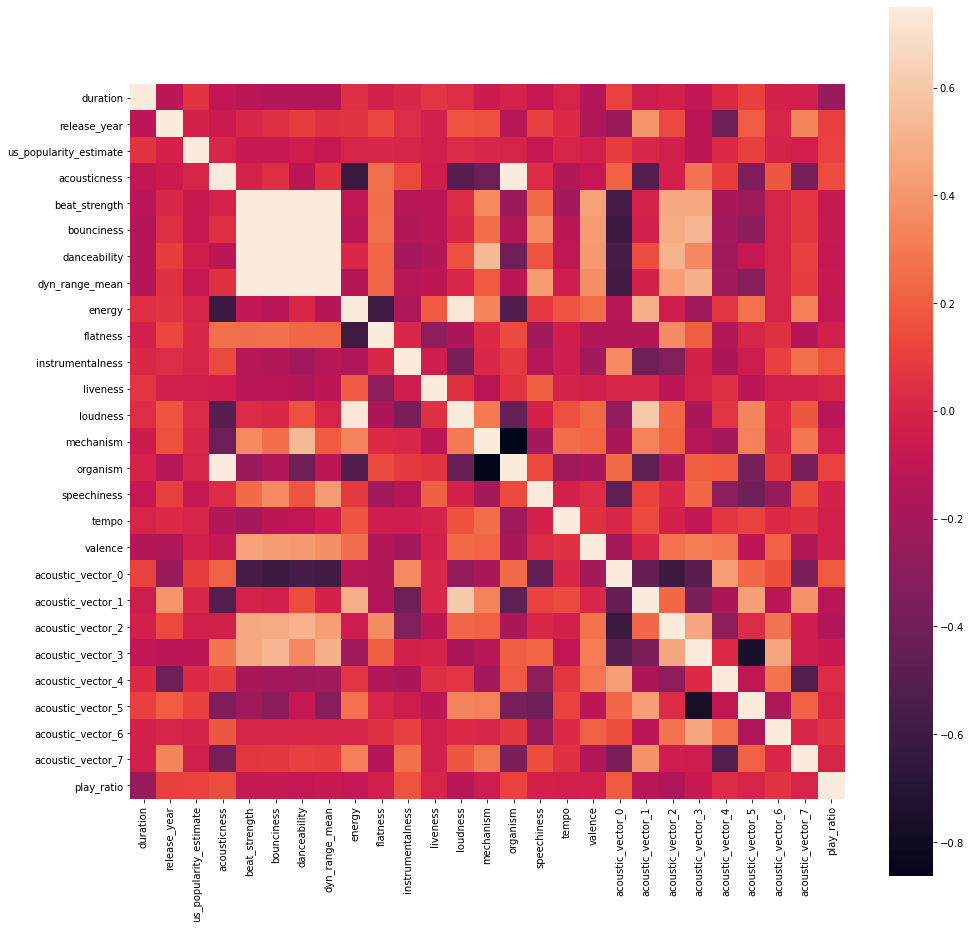

In [273]:
import seaborn

# Create heat map for dataset features
corr_mat = tracks2.corr()
fig = plt.figure(figsize = (16, 16))
seaborn.heatmap(corr_mat, vmax=.75, square = True)
plt.show()

Thankfully, it doesn't appear like multicollinearity is a huge factor in the feature selection differences between AutoGluon and our various regressors. AutoGluon's top-selected features-- 'duration', 'us_popularity_estimate', 'release_year' and 'acoustic_vector_0'-- do not have worryingly high correlations with 'loudness', 'acoustic_vector_1', 'acoustic_vector_3', 'acoustic_vector_7', 'dyn_range_mean' or 'organism', with one exception. 'acoustic_vector_0' is highly correlated with 'dyn_range_mean', which was very highly-ranked by our linear regression model and somewhat highly-ranked by the RandomForest, if not in the uppermost echelon of importance. Besdies that pair, the highest correlation between the two groups of features is between 'acoustic_vector_0' and 'acoustic_vector_3'. However, as mentioned earlier in this project, Spotify doesn't give much explanation for the meaning of their proprietary features, so the semantic reasoning behind these 'acoustic_vector' correlations in particular is hard to ascertain. Moreover, there's not much we can do about it, but it's reassuring that these opaque collinearities are not more of a glaring issue in this project. So, there may be a small amount of multicollinearity influencing feature selection, but there isn't enough to greatly affect this project's insights. After all, the highest correlations on this heatmap do not tend to represent opposing feature selections between the models.

In [6]:
# Check summary and overall architecture of AutoGluon ensemble
results = predictor_playratio.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val  pred_time_val     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   weighted_ensemble_k0_l1  -0.100613       0.589464  1049.872033                0.001691           0.495940            1       True         10
1    ExtraTreesRegressorMSE  -0.101412       0.303263   157.696837                0.303263         157.696837            0       True          2
2        NeuralNetRegressor  -0.101635       0.051770   210.995382                0.051770         210.995382            0       True          8
3  RandomForestRegressorMSE  -0.101720       0.204670   676.276057                0.204670         676.276057            0       True          1
4   LightGBMRegressorCustom  -0.101738       0.035971     6.190336                0.035971           6.190336            0       True          9
5         LightGBMRegressor  -0.101823       0.013113     2.150315  

/home/ubuntu/anaconda3/envs/AG_env/lib/python3.7/site-packages/autogluon/utils/plots.py:141: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


Checking AutoGluon's fit summary, we can infer some interesting tidbits about how it reached its final predictions, and how its behavior might have influenced its superior performance. Although there is not a robust amount of detail provided for most of the regressors listed here, which were weighted into AutoGluon's final ensemble, some details stick out. 

For one, out of all of AutoGluon's tree-based regressors, The ExtraTreesRegressor that AutoGluon utilized performed significantly better than both our own ExtraTreesRegressor and the RandomForest we utilized earlier in this experiment, averaging around 10.17% error compared to 10.98% and 10.86% respectively. This is perplexing, and hints that part of the poor performance of the ExtraTrees forest tested earlier in this project could have to do with cross-validation procedures or hyperparameter selection. Notwithstanding, it appears that AutoGluon chose not to tune its hyperparameters for any of its models for this problem (which it is free to do automatically, without user specification). The default hyperparameters for the LightGBMRegressorCustom regressor (a tree-based gradient boosting regressor) give us some insight to the differing performance: for one, it is built with a much higher maximum number of leaves (128) than the forests we used (8) (this choice was partially a result of the prior hyperparameter search to the GridSearch seen earlier in this project, which resulted in the GridSearchCV regressor picking a max_depth of 4 when given tuning choices spanning from 4 to 100. Nevertheless, this is worthy of note for future iterations of this project). The custom regressor is also specified to have a much higher fraction of features per tree (90%) than our RandomForest (10/26, ~38%). Although boosted tree models' stochasticity makes them a somewhat imbalanced comparison for a normal RandomForest, these hyperparameter specifications are still purported to resemble the default parameters that the other tree-based regressors use for this regression problem, so these differences give some insight on how AutoGluon's forests so clearly outperformed our own.

Despite the data science field's near-unanimous agreement on the contrary, the neural network regressor used by AutoGluon appears to have been one of its best performing constituents in this particular problem, only being slightly beaten by the ExtraTrees regressor. This is surprising on its own; the Neural Network's presence in AutoGluon's aggregation has been said to be mostly due to its benefit for the overall ensemble, which comes from neural networks' unique decision boundaries compared to tree-based models. Regardless, looking at [the architecture of AutoGluon's neural network](https://arxiv.org/pdf/2003.06505.pdf) one can imagine how the unique features of its feedforward neural network, such as its early parallel linear skip-connection made to the output layer, might influence its performance. Although we are given little precise information about the network's performance in this case, we can see that its training lasted significantly longer than the neural network we used earlier. This tells us very little-- a more complex neural network takes much longer to train than network as simple as the one we used, regardless of the potential units per layer. But altogether, the superior performance certainly hints that Dense block layers as used in AutoGluon's neural network architecture could be a good way to start improving the simple neural network design we used for regression problems like this.

Of course, the most alluring aspect of AutoGluon (and AutoML in general) is the capability to weigh the influence of several regressors and create custom ensembles that yield optimally-performing predictions. That's exactly what we've seen in the above results: the 'can_infer' column indicates all of the regressors trained were incorporated into the final ensemble, which by the 'stack_level' column we know was the only regressor to take in data from other regressors. With more complex tasks, it would be interesting to see how AutoGluon's behavior differs in this regard, and how it may seek to create sub-ensembles or input data from basic regressors to other base regressors before forming a final ensemble. Regardless, the results speak for themselves.

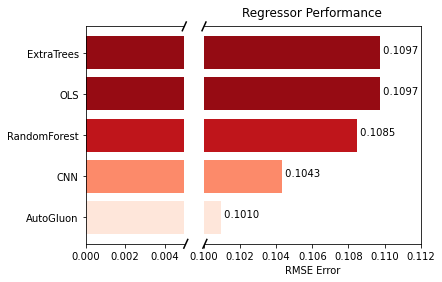

In [59]:
import matplotlib.pyplot as plt
import numpy as np

# Collect regressor performance data under one dictionary, and rescale coloring scheme
regressors = {'AutoGluon':0.10096534, 'CNN':0.10430304, 'RandomForest':0.10845876, 'OLS':0.10972723, 'ExtraTrees':0.10974964}
keys, values = zip(*regressors.items())
my_cmap = plt.get_cmap("Reds")
rescale = lambda y: (y - np.min(y) + .001) / (np.max(y) - np.min(y) +.002)

# Create subplots and bar graph
f, axs = plt.subplots(1, 3, sharey=True)
ax, ax2, ax3 = axs
ax.barh(keys, values, color=my_cmap(rescale(values)))
ax.set_xlim(0, .005)
ax.spines['right'].set_visible(False)
gs = axs[1].get_gridspec()
ax2.remove()
ax3.remove()
axbig = f.add_subplot(gs[1:])
axbig.barh(keys, values, color=my_cmap(rescale(values)))
axbig.set_xlim(.1, .112)
axbig.tick_params(left=False)
axbig.spines['left'].set_visible(False)
axbig.axes.get_yaxis().set_visible(False)

# Add labels
plt.title("Regressor Performance", pad=10)
plt.xlabel("RMSE Error")
for i, val in enumerate(values):
    plt.text(val, i, " " + f'{val:.4f}')

# Create slashes to indicate discontinuity
d = .02 
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((1.015+d, 1.015-d), (+d, -d), **kwargs)        
ax.plot((1-d, 1+d), (1-d, 1+d), **kwargs) 
kwargs.update(transform=ax2.transAxes) 
axbig.plot((-d, +d), (1-d, 1+d), **kwargs) 
axbig.plot((.009-d, .009+d), (-d, +d), **kwargs) 
plt.show()

#### Wrap-up

I greatly enjoyed this project, and I hope that it was not too much of a chore to read.

Thank you for visiting this page. :)